<a href="https://colab.research.google.com/github/Kiwihead15/Car_Detector/blob/main/Tea_NLP_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing review's messages in a dataframe

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyldavis
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 65.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 KB 30.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import json
import re
import nltk
import gensim 
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis.lda_model
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from collections import Counter
from nltk.util import ngrams, bigrams, trigrams
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline
from wordcloud import WordCloud 
from nltk import Text
nltk.download('gutenberg')
nltk.download('stopwords')
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
import warnings
import contractions

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [4]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Reads input files and generate a pandas dataframe 

In [5]:
words_file1 = open("/content/drive/MyDrive/Colab_Notebooks/Tes/USA RTD Group 1.txt", "r")
try:
    content1 = words_file1.read()
    #words = content.split(" ")
finally:
    words_file1.close() 

words_file2 = open("/content/drive/MyDrive/Colab_Notebooks/Tes/USA RTD Group 2.txt", "r")
try:
    content2 = words_file2.read()
    #words_custom2 = content.split(" ")
finally:
    words_file2.close() 

words_file3 = open("/content/drive/MyDrive/Colab_Notebooks/Tes/USA RTD Group 3.txt", "r")
try:
    content3 = words_file3.read()
    #words_custom3 = content.split(" ")
finally:
    words_file3.close() 

words_file4 = open("/content/drive/MyDrive/Colab_Notebooks/Tes/USA RTD Group 4.txt", "r")
try:
    content4 = words_file4.read()
    #words_custom4 = content.split(" ")
finally:
    words_file4.close() 


In [6]:
all_words = content1 + content2 + content3 + content4

# Word level analysis

## Stop-words analysis

In [7]:
# Builds a stop_words list from a stop_words_custom_file
stop_words_file = open("/content/drive/MyDrive/Colab_Notebooks/Tes/SmartStoplist.txt", "r")
try:
    content = stop_words_file.read()
    stop_words_custom = content.split(",")
    stop_words_custom = [i.replace('"',"").strip() for i in stop_words_custom]
finally:
    stop_words_file.close() 

In [8]:
# Set a stopwords from stop_words_custom_file, or the nltk spotwords
#stop_words = set(stopwords.words('english'))
stop_words = set(stop_words_custom)

## Key-words analysis

In [9]:
# Set which stemmer or lemmatizer will be used in the preprocess function. WordNetLemmatizer, PorterStemmer, SnowballStemmer
lemmatizer = WordNetLemmatizer()  

In [10]:
def preprocess(raw_text):
    
    # expand contractions
    raw_wo_con = contractions.fix(raw_text)
    
    # tokenize
    tokens = nltk.tokenize.word_tokenize(raw_wo_con)

    # cap-lower letters
    words_low_case = [word.lower() for word in tokens]

    # regular expression keeping only letters 
    letters_only_text = [re.sub("[^a-zA-Z]", " ", word) for word in words_low_case]  # replace "[^a-zA-Z]" for "[^a-zA-Z0-9\s]+" if you want to keep letters and numbers
    
    # remove stopwords
    cleaned_words = [w for w in letters_only_text if not w in stop_words]
     
    # stemm or lemmatise words
    stemmed_words = [lemmatizer.lemmatize(word) for word in cleaned_words]   #don't forget to change "stem(word)" to "lemmatize(word)" if you are using a lemmatizer
    
    # converting list back to string
    return (" ".join(stemmed_words))

Running preprocess function will generate a new column with the result. 

Column 'message' contains the original message, column 'prep' contains the messages preprocessed.

The next analysis will be applied over one or both columns depending 
on the pourpuse. 

In [11]:
all_words_processed = preprocess(all_words)   # Apply preproccess function on 'message' field to each row, and throw the result into the 'prep' field


In [12]:
all_words_proce = all_words_processed.split()

### Comparing lexical diversity (tokens/token-types)  before vs after processes.

In [13]:
corpus = []                             # list of tokens for Topic modeling exploration far below

#looping through all incidents and joining them to one text
for arg in all_words_proce:
    tokens = arg.split()  
    corpus.append(tokens)

counts  = FreqDist(all_words_proce)   # dictionary with words as keys, and quantity of this keys in the text as value.
vocab   = len(counts.keys())
words   = sum(counts.values())
lexdiv  = round(float(words) / float(vocab),2)
hapax   = len(counts.hapaxes())
print ("After preprocess message_Corpus has", words, "tokens. Tokens are grouped in",  vocab ,"token-types.")
print ("The lexical diversity (tokens/token-types) is",lexdiv)
print (round((hapax/vocab)*100,2), '% of token-types are',hapax,'hapaxes')


After preprocess message_Corpus has 21630 tokens. Tokens are grouped in 2753 token-types.
The lexical diversity (tokens/token-types) is 7.86
44.53 % of token-types are 1226 hapaxes


In [14]:
corpus

[['translate'],
 ['content'],
 ['drive'],
 ['mydrive'],
 ['colab'],
 ['notebooks'],
 ['tes'],
 ['usa'],
 ['rtd'],
 ['group'],
 ['m'],
 ['a'],
 ['content'],
 ['drive'],
 ['mydrive'],
 ['colab'],
 ['notebooks'],
 ['tes'],
 ['usa'],
 ['rtd'],
 ['group'],
 ['txt'],
 ['recording'],
 ['progress'],
 ['cool'],
 ['group'],
 ['stuff'],
 ['love'],
 ['chance'],
 ['virtually'],
 ['meet'],
 ['officially'],
 ['name'],
 ['called'],
 ['ahead'],
 ['understand'],
 ['folk'],
 ['united'],
 ['state'],
 ['today'],
 ['guess'],
 ['favorite'],
 ['drink'],
 ['introduction'],
 ['favorite'],
 ['drink'],
 ['jamie'],
 ['york'],
 ['living'],
 ['atlanta'],
 ['year'],
 ['guess'],
 ['atlanta'],
 ['favorite'],
 ['drink'],
 ['obsessed'],
 ['topo'],
 ['chico'],
 ['bubble'],
 ['busy'],
 ['love'],
 ['sensation'],
 ['love'],
 ['clean'],
 ['palate'],
 ['quenches'],
 ['thirst'],
 ['mix'],
 ['kind'],
 ['thing'],
 ['juice'],
 ['favorite'],
 ['drink'],
 ['reason'],
 ['set'],
 ['good'],
 ['jump'],
 ['start'],
 ['andrew'],
 ['graham

### Show the Most Common Words
In order to get an idea about a dataset, it's useful to have a look at the most common key words. 

In [15]:
#FreqDist(all_prep_words.split()).most_common(20)       # Also Counter(all_words.split()).most_common(20)

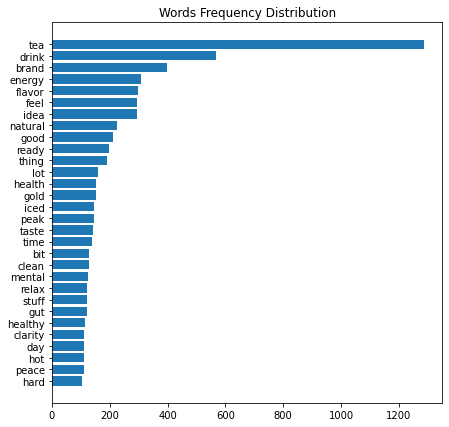

In [16]:
#creating a dictionary that shows occurances of the 20th most common n-grams in text
words_dic = dict(Counter(all_words_proce).most_common(30))

## Convert to Pandas series for easy plotting
words_freqdist = pd.Series(words_dic)

## Setting figure & ax for plots
fig, ax = plt.subplots(figsize=(7,7))

## Setting plot to horizontal for easy viewing + setting title + display  
x = words_freqdist.values
y = words_freqdist.index

ax.barh(y, x)
ax.invert_yaxis()  # labels read top-to-bottom

plt.title('Words Frequency Distribution')

plt.show();

In [17]:
#FreqDist(all_prep_words.split()).plot(30,title='Words Frecuency Distribution')


### Show a cloud of words

In [18]:
all_words_to_cloud = all_words_processed

In [19]:
all_words_to_cloud

'translate    content drive mydrive colab notebooks tes usa rtd group   m a          content drive mydrive colab notebooks tes usa rtd group   txt                  recording progress     cool   group                 stuff   love chance virtually meet                  officially   name     called                    ahead   understand   folk                  united state today     guess                    favorite drink introduction                        favorite drink                      jamie   york   living                  atlanta         year   guess atlanta   favorite                  drink       obsessed topo chico   bubble                  busy     love sensation   love                  clean palate   quenches thirst   mix kind thing juice                    favorite drink   reason   set good                    jump     start                        andrew graham   georgia california                    living georgia   favorite drink vanilla flavor inshore                     ta

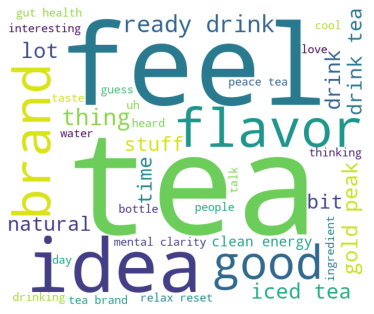

In [20]:
# Build a worldcloud image

wordcloud = WordCloud(width =600, height = 500, 
                background_color ='white', 
                min_font_size = 16).generate(all_words_to_cloud) 
  
# plot the WordCloud image
                     
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### Show the most common ngrams

In [21]:
#splitting sentence into bigrams and trigrams
biagrams = list (bigrams(all_words_proce))
triagrams = list (trigrams(all_words_proce))
n_grams= biagrams + triagrams

In [22]:
#creating a dictionary that shows occurances of the 20th most common n-grams in text
n_gram_dic = dict(Counter(n_grams).most_common(20))

ngram_joined = {'_'.join(k):v for k,v in sorted(n_gram_dic.items(), key=lambda item:item[1], reverse=True)}
ngram_joined

{'ready_drink': 175,
 'iced_tea': 140,
 'gold_peak': 140,
 'drink_tea': 121,
 'clean_energy': 111,
 'mental_clarity': 102,
 'ready_drink_tea': 91,
 'gut_health': 89,
 'tea_brand': 86,
 'relax_reset': 86,
 'peace_tea': 81,
 'mindful_indulgence': 72,
 'hot_tea': 64,
 'energy_drink': 57,
 'green_tea': 54,
 'energy_balance': 50,
 'clean_energy_balance': 49,
 'hard_tea': 46,
 'drink_iced': 46,
 'drink_iced_tea': 46}

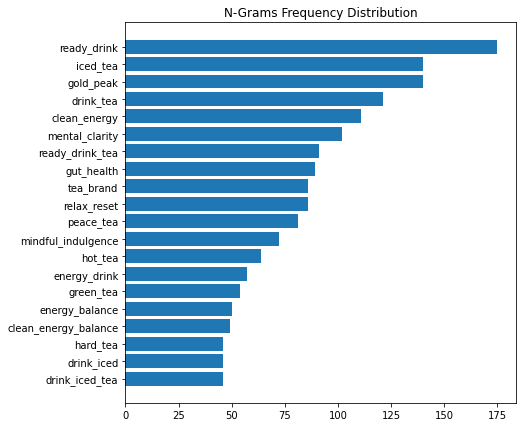

In [23]:
## Convert to Pandas series for easy plotting
ngram_freqdist = pd.Series(ngram_joined)

## Setting figure & ax for plots
fig, ax = plt.subplots(figsize=(7,7))

## Setting plot to horizontal for easy viewing + setting title + display  
x=ngram_freqdist.values
y=ngram_freqdist.index

ax.barh(y, x)
ax.invert_yaxis()  # labels read top-to-bottom

plt.title('N-Grams Frequency Distribution')

plt.show();

## Initial exploration of filtered messages with NLTK.text.Text function:
The nltk.text.Text class is a wrapper around a sequence of simple (string) tokens - intended only for the initial exploration of text. It has the following methods:

* common_contexts
* concordance
* collocations
* count
* plot
* findall
* index
* similar

You shouldn't use this class in production level systems, but it is useful to explore (small) snippets of text in a meaningful fashion.

### Analysis over 'message' and/or 'prep' columns.

In [24]:
filtered_reviews_prep_messages = Text(all_words_proce)
filtered_reviews_messages = Text(all_words.split())

### Ploting key words distributions:

Select from the plot above the most meaniful words. Don´t use stem, since analysis runs over 'message' column.

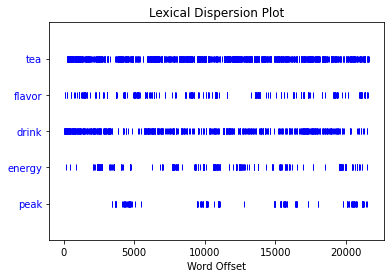

In [25]:
filtered_reviews_prep_messages.dispersion_plot(["tea", "flavor",'drink','energy', 'peak']) #word's dispersion

## Analizing a key-word ("focus_word") taken from the most common key words in the filtered rating's messages

In [26]:
focus_word = 'natural'

### Show "focus_word" ocurrences:

In [27]:
filtered_reviews_prep_messages.count(focus_word)  #focus_word's ocurrences

225

In [28]:
counts.freq(focus_word) * 100 # percentage of the corpus for this token

1.0402219140083218

### Explore the context of the "focus_word" in the original messages

In [29]:
filtered_reviews_prep_messages.concordance(focus_word, width=100, lines=25)   # The corcordance function performs a search for the given token and then also provides the surrounding context:

Displaying 25 of 225 matches:
and bottle stuff mind role play guess lighter natural tasting drink tea caffeinated bit energy wire
ne drink coffee drink tea occasionally prefer natural water seltzer depends seltzer caffeine specif
drink tea satisfied craving unique experience natural healthy guess initial reaction idea thinking 
ntail opinion expect healthy tea great flavor natural healthy expected health wise people mentioned
ng initial reaction idea indulgent experience natural healthy jordan feel ready flavor texture star
ed corn syrup healthier talking wanting sweet natural healthy sweet curious healthy healthier optio
ay explore flavor combination satisfy craving natural healthy drink explore flavor natural healthy 
 craving natural healthy drink explore flavor natural healthy drink supermarket sample familiar hea
time buying variety flavor flavor trust brand natural healthy deliver natural healthy calorie sweet
or flavor trust brand natural healthy deliver natural healthy calorie 

### Explore Distributional similarity: 
Find other words which appear in the
same contexts as the "focus_word"; list most similar words first.

In [30]:
filtered_reviews_prep_messages.similar(focus_word, num = 30) 

tea ingredient lot feel clean option fruit good flavor expect energy
great bit sugar sweet healthy pretty artificial peace herb peach
called guess drink year juice work caffeine water refreshing


In [31]:
filtered_reviews_prep_messages.common_contexts(focus_word.split(), num = 30)

experience_healthy regain_focus texture_healthy flavor_healthy
craving_healthy healthier_pure convenient_energy provided_sustainable
alcohol_healthy natural_ingredient healthy_natural natural_energy
healthier_bit ingredient_ingredient calorie_sweetener lighter_tasting
prefer_water sweet_healthy brand_healthy deliver_healthy
fermented_hard tea_hard lot_flavor idea_stuff average_artificial
gym_energy talked_energy tea_energy sort_pure emphasize_buy


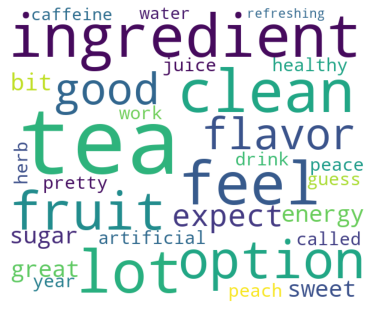

In [32]:
# Build a worldcloud image

wordcloud = WordCloud(width =600, height = 500, 
                background_color ='white', 
                min_font_size = 16).generate('tea ingredient lot feel clean option fruit good flavor expect energy great bit sugar sweet healthy pretty artificial peace herb peach called guess drink year juice work caffeine water refreshing') 
  
# plot the WordCloud image
                     
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## Collocations

In [33]:
filtered_reviews_prep_messages.collocations(num=30, window_size=3) # Collocations in the filtered_reviews_prep_messages

gold peak; mental clarity; ready drink; relax reset; clean energy; gut
health; mindful indulgence; iced tea; clean balance; pure leaf; energy
balance; drink tea; natural healthy; peace tea; clean imbalance;
flavor combination; future set; asian brand; green tea; ready iced;
initial reaction; energy imbalance; clear mind; shake shake; hot tea;
ready tea; satisfy craving; ice tea; surprising combination; twisted
tea


In [34]:
focus_collocation = ["natural", "healthy"]

In [35]:
filtered_reviews_prep_messages.concordance(focus_collocation, width = 120, lines=25) 

Displaying 25 of 45 matches:
ready drink tea satisfied craving unique experience natural healthy guess initial reaction idea thinking ready drink te
lthy entail opinion expect healthy tea great flavor natural healthy expected health wise people mentioned antioxidant s
romising initial reaction idea indulgent experience natural healthy jordan feel ready flavor texture staring word drink
rocessed corn syrup healthier talking wanting sweet natural healthy sweet curious healthy healthier option danny feelin
fe today explore flavor combination satisfy craving natural healthy drink explore flavor natural healthy drink supermar
atisfy craving natural healthy drink explore flavor natural healthy drink supermarket sample familiar hear benefit open
er anytime buying variety flavor flavor trust brand natural healthy deliver natural healthy calorie sweetener rest expl
y flavor flavor trust brand natural healthy deliver natural healthy calorie sweetener rest exploring flavor satisfying 
 sweetener 

# Topic modeling exploration with pyLDAvis

In [36]:
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
import seaborn as sns
from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm
from gensim import models,corpora

In [37]:
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [39]:
Lda = models.LdaMulticore
coherenceList_umass = []
coherenceList_cv = []
num_topics_list = np.arange(3,26)
for num_topics in tqdm(num_topics_list):
    lda= Lda(bow_corpus, num_topics=num_topics,id2word = dic, 
             passes=20,chunksize=4000,random_state=43)
    cm = CoherenceModel(model=lda, corpus=bow_corpus, 
                        dictionary=dic, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    cm_cv = CoherenceModel(model=lda, corpus=bow_corpus,
                           texts=corpus, dictionary=dic, coherence='c_v')
    coherenceList_cv.append(cm_cv.get_coherence())
    vis = pyLDAvis.gensim.prepare(lda, bow_corpus, dic)
    pyLDAvis.save_html(vis,f'pyLDAvis_{num_topics}.html')

  0%|          | 0/23 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


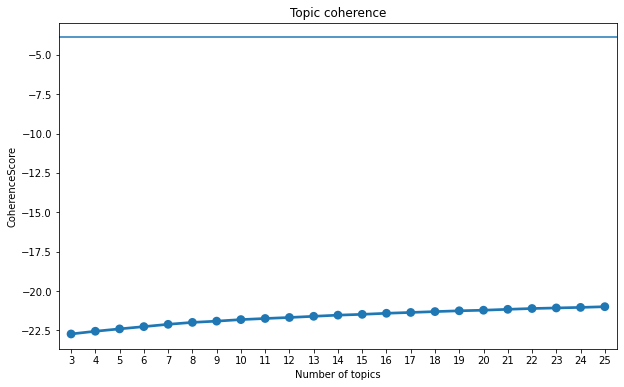

In [40]:
plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'CoherenceScore':coherenceList_umass})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
sns.pointplot(x='Number of topics',y= 'CoherenceScore',data=plotData)
plt.axhline(y=-3.9)
plt.title('Topic coherence')
plt.savefig('Topic coherence plot.png')

In [38]:
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                   num_topics = 3,
                                   id2word = dic,
                                   passes = 20,
                                   workers = 2,
                                   chunksize=2000,
                                   batch=False,
                                   alpha='symmetric',
                                   eta=None,
                                   decay=0.5,
                                    offset=1.0, 
                                     eval_every=10, 
                                     iterations=50, 
                                     gamma_threshold=0.001, 
                                     random_state=None, 
                                     minimum_probability=0.01, 
                                     minimum_phi_value=0.01, 
                                     per_word_topics=False, 
                                     dtype=np.float32)
                                    
lda_model.show_topics()

[(0,
  '0.038*"flavor" + 0.028*"gold" + 0.020*"lot" + 0.017*"stuff" + 0.017*"health" + 0.017*"taste" + 0.014*"relax" + 0.014*"day" + 0.013*"bottle" + 0.012*"guess"'),
 (1,
  '0.154*"tea" + 0.058*"drink" + 0.038*"idea" + 0.037*"feel" + 0.025*"good" + 0.023*"thing" + 0.018*"clean" + 0.017*"clarity" + 0.016*"iced" + 0.015*"ingredient"'),
 (2,
  '0.060*"brand" + 0.037*"energy" + 0.030*"natural" + 0.027*"peak" + 0.022*"ready" + 0.021*"peace" + 0.019*"mental" + 0.018*"time" + 0.016*"bit" + 0.013*"sweet"')]

In [41]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, bow_corpus, dic)
vis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.314173  0.067402       1        1  34.139467
0      0.095749 -0.292627       2        1  33.590475
2      0.218425  0.225225       3        1  32.270058, topic_info=        Term         Freq        Total Category  logprob  loglift
146      tea  1136.000000  1136.000000  Default  30.0000  30.0000
117    brand   421.000000   421.000000  Default  29.0000  29.0000
32     drink   428.000000   428.000000  Default  28.0000  28.0000
442     idea   283.000000   283.000000  Default  27.0000  27.0000
63    flavor   274.000000   274.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
255     cold    37.526919    38.130511   Topic3  -5.2257   1.1151
77      work    37.363470    37.966974   Topic3  -5.2301   1.1150
143     type    35.987235    36.591132   Topic3  -5.2676   1.1144
1057   fruit    32.327109    32.931418   Topic3  -5.3749   1.1125
465   future    31.379942    31.983936   Topic3  -5.4046   1.1120

[120 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
572       1  0.991853  alcohol
613       3  0.982114  arizona
405       2  0.989232    asian
214       2  0.995582  balance
322       3  0.987822  benefit
...     ...       ...      ...
143       3  0.983845     type
541       3  0.997093       uh
97        1  0.992639    water
77        3  0.974531     work
38        1  0.988222     year

[90 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])